# Ontology closest category evaluation

In [45]:
from graphai.core.common.ontology_utils.data import OntologyData, db_results_to_pandas_df
from db_cache_manager.db import DB
from graphai.core.common.config import config
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
db_manager = DB(config['database'])

In [2]:
ontology_data = OntologyData(test_mode=True, test_ratio=0.3, random_state=20)
ontology_data.load_data()

1497301 1497301 1497301


Let's see the size of the test and training sets:

In [3]:
print(ontology_data.get_test_category_concept().shape[0], ontology_data.get_category_concept_table().shape[0])

5921 13818


In [4]:
test_category_concept = ontology_data.get_test_category_concept()
test_concepts = test_category_concept['to_id'].values.tolist()
test_labels = test_category_concept['from_id'].values.tolist()

In [5]:
def predict_all(model: OntologyData, x: list, avg='linear', coeffs=(1, 4), top_down=True, n=5):
    y = list()
    for p in x:
        best_cats, best_scores, selected_d3_category, best_clusters = \
            model.get_concept_closest_category(p, avg=avg, coeffs=coeffs, top_n=n, use_depth_3=top_down,
                                               return_clusters=None)
        if best_cats is None:
            best_cats = list()
        y.append(best_cats)
    return y

def get_top_k_list_of_lists(res, k):
    max_k = max([len(x) for x in res])
    if k > max_k:
        print('Maximum n is %d, cannot return evaluation metrics @ %d' % (max_k, k))
        return None
    return [set(x[:k]) for x in res]

def eval_at_k(res, labels, k):
    results_to_evaluate = get_top_k_list_of_lists(res, k)
    n_correct = sum([1 if labels[i] in results_to_evaluate[i] else 0 for i in range(len(results_to_evaluate))])
    n_total = len(labels)
    acc = n_correct / n_total
    return acc

def get_errors_at_k(res, concepts, labels, k):
    results_to_evaluate = get_top_k_list_of_lists(res, k)
    error_indices = [i for i in range(len(results_to_evaluate)) if labels[i] not in results_to_evaluate[i]]
    return [concepts[i] for i in error_indices]

def get_max_accuracy(res):
    return len([x for x in res if len(x) > 0]) / len(res)
    

## Evaluating different combinations

In [6]:
parameter_list = list(
    itertools.product(['log', 'linear'], [(1, 1), (10, 1), (1, 10), (1, 100), (0, 1)],
                      [False, True])
)

In [7]:
all_results = [
    predict_all(ontology_data, test_concepts, avg=params[0], coeffs=params[1], top_down=params[2], n=10)
    for params in parameter_list
]

In [8]:
all_eval_at_1 = [eval_at_k(results, test_labels, 1) for results in all_results]

In [9]:
all_eval_at_5 = [eval_at_k(results, test_labels, 5) for results in all_results]

In [10]:
all_eval_at_10 = [eval_at_k(results, test_labels, 10) for results in all_results]

In [11]:
all_max_acc = [get_max_accuracy(results) for results in all_results]

### Results

#### Accuracy @ 1

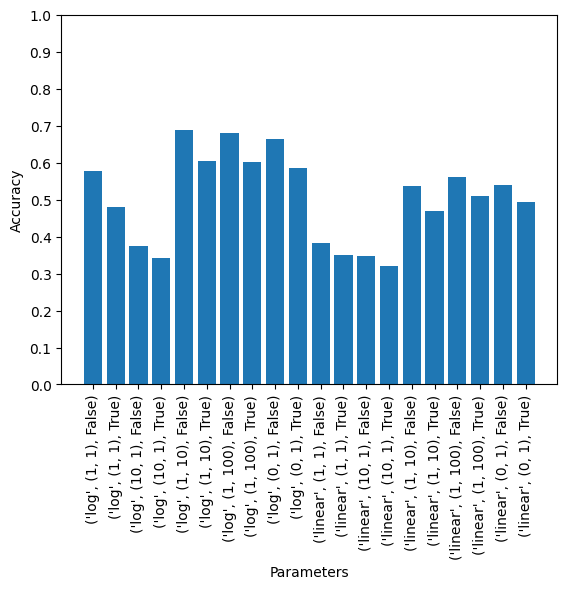

In [41]:
plt.bar([str(x) for x in parameter_list], height=all_eval_at_1)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Parameters')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

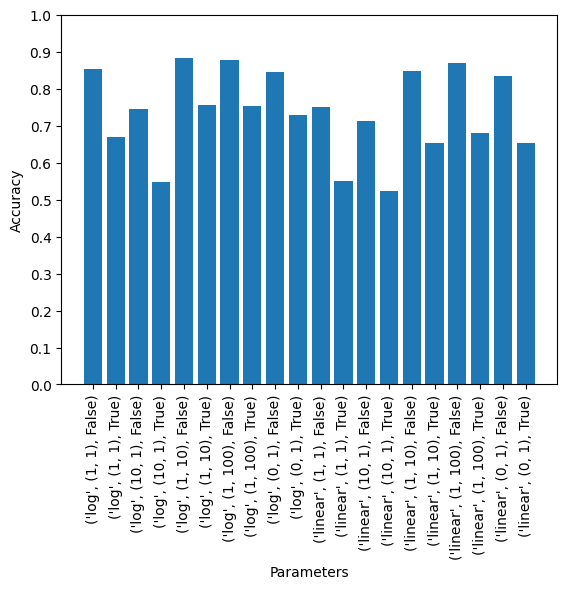

In [39]:
plt.bar([str(x) for x in parameter_list], height=all_eval_at_5)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Parameters')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

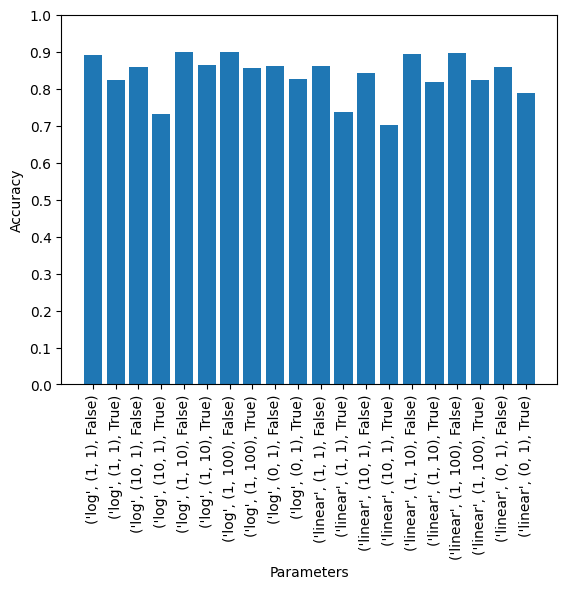

In [40]:
plt.bar([str(x) for x in parameter_list], height=all_eval_at_10)
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Parameters')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

Let's see the results for the best parameters:

Best params:

In [42]:
parameter_list[np.argmax(all_eval_at_1)], parameter_list[np.argmax(all_eval_at_5)]

(('log', (1, 10), False), ('log', (1, 10), False))

Accuracy @1, @5 and @10:

In [16]:
all_eval_at_1[np.argmax(all_eval_at_1)], all_eval_at_5[np.argmax(all_eval_at_1)], all_eval_at_10[np.argmax(all_eval_at_1)]

(0.689072791758149, 0.8821145076845127, 0.8998479986488769)

What are the conclusions that we can draw here?
* log >>>>>>> linear
* Top-down search always makes the results worse
* Concepts are much more important than anchors, but anchor pages are useful after all and removing them or de-emphasizing them too much reduces accuracy.

#### Analyzing the errors

In [17]:
best_index = np.argmax(all_eval_at_1)
best_params = parameter_list[best_index]
best_results = all_results[best_index]

In [18]:
errors_at_5 = get_errors_at_k(best_results, test_concepts, test_labels, 5)

In [19]:
len(errors_at_5), len(test_labels)

(698, 5921)

In [20]:
test_concept_names = ontology_data.get_test_concept_names()
concept_id_to_name = test_concept_names.set_index('id')['name'].to_dict()
errors_at_5_concept_names = test_concept_names.loc[test_concept_names['id'].apply(lambda x: x in errors_at_5)]

In [21]:
errors_at_5_concept_names

,id,name
0,100034,Military engineering
32,10044864,Research question
50,1006651,Amorphous carbon
65,10096030,Informal education
112,1016556,Induced seismicity
...,...,...
19419,9553738,Ensemble Kalman filter
19558,9764915,Bicarbonate buffer system
19591,9801859,Marketplace
19622,9848870,Energy efficiency in transport


In [22]:
errors_at_5_categories = test_category_concept.loc[test_category_concept.to_id.apply(lambda x: x in errors_at_5)]
errors_at_5_categories = errors_at_5_categories.assign(count=1)[['from_id', 'count']].groupby('from_id').sum().reset_index()
category_full_sizes = pd.concat([ontology_data.get_test_category_concept(), ontology_data.get_category_concept_table()]).assign(count=1)[['from_id', 'count']].groupby('from_id').sum().reset_index()
category_test_sizes = test_category_concept.assign(count=1)[['from_id', 'count']].groupby('from_id').sum().reset_index()
errors_at_5_categories = pd.merge(errors_at_5_categories, category_full_sizes, how='inner',
                                  on='from_id', suffixes=('_errors', '_total'))
errors_at_5_categories = pd.merge(errors_at_5_categories, category_test_sizes, how='inner',
                                  on='from_id').rename(columns={'count': 'count_test'})
errors_at_5_categories['error_ratio'] = errors_at_5_categories['count_errors'] / errors_at_5_categories['count_test'] 

In [23]:
errors_at_5_categories.sort_values(by=['error_ratio', 'count_errors'], ascending=False)

,from_id,count_errors,count_total,count_test,error_ratio
294,topics-in-geology,17,40,17,1.000000
161,interpreters,7,15,7,1.000000
95,ecosystem-ecology,6,19,6,1.000000
114,enzyme-kinetics,6,12,6,1.000000
215,plasma-engineering,6,18,6,1.000000
...,...,...,...,...,...
219,polymer-chemistry,1,113,39,0.025641
105,entities-in-astrophysics,1,154,40,0.025000
177,microprocessors,1,143,41,0.024390
2,abstract-algebra,1,151,51,0.019608


In [24]:
full_error_categories = errors_at_5_categories.loc[errors_at_5_categories.error_ratio == 1.0].from_id.values.tolist()

In [37]:
# current_category = full_error_categories[1]
current_category = 'geopolitics'
current_category_concepts = test_category_concept.loc[test_category_concept.from_id == current_category, 'to_id'].values.tolist()
indices = [test_concepts.index(x) for x in current_category_concepts]
predicted_labels = [best_results[i][:5] for i in indices]
current_wrong_predictions_df = pd.DataFrame(columns=['concept_id', 'concept_name', 'predicted_category'])
current_wrong_predictions_df['concept_id'] = current_category_concepts
current_wrong_predictions_df['concept_name'] = [concept_id_to_name[x] for x in current_category_concepts]
current_wrong_predictions_df['predicted_category'] = predicted_labels
current_wrong_predictions_df = current_wrong_predictions_df.explode('predicted_category')

In [38]:
current_wrong_predictions_df

,concept_id,concept_name,predicted_category
0,15489197,Province,global-cities
0,15489197,Province,geopolitics
0,15489197,Province,early-modern-period
0,15489197,Province,world-war
0,15489197,Province,topics-in-climate
1,18348178,Chlorine production,coordination-chemistry
1,18348178,Chlorine production,writers
1,18348178,Chlorine production,entities-in-process-engineering
1,18348178,Chlorine production,entities-in-psychiatry
1,18348178,Chlorine production,entities-in-psycholinguistics


Many of the wrongly categorized concepts are extremely sparse in terms of their rows in the concept-concept table. For example, "Kilocalorie per mole" has only two edges, to "Biology" and "Energy". This means that its predicted categories are effectively random and thus inaccurate.

Another issue with some of the wrongly categorized concepts is that in reality, their predicted categories are as accurate as, if not more accurate than their assigned "ground truth". Errors like this fall under two categories:

1. Some clusters are assigned to the wrong category (e.g. cluster 413, containing 'PDF' and 'SVG' is assigned to 'interpreters', rather than, say, 'file formats' or '2d-computer-graphics') and that means that the effective re-assignment is more correct than the ground truth.
2. Some clusters have wrong concepts in them. Cluster 449 has a combination of geography concepts and chemistry concepts.

Here are a few takeaways:

* Interestingly enough, in a roundabout way, this evaluation method provides us with a way of detecting obvious mistakes in the ontology (which are often wrongly-assigned clusters), which can then be corrected using the method that finds the closest category for a cluster.
* The issue of sparse areas of the concept-concept graph may be something that we can solve by introducing a secondary method of computing similarity scores: word embeddings. I need to look into this.

#### Evaluation based on importance of concepts in publications

In [49]:
concepts_in_publications = db_results_to_pandas_df(
    db_manager.execute_query(
        "SELECT b.id, b.name, a.score FROM "
        "(SELECT SUM(score) AS score, to_id FROM graph_new.Edges_N_Publication_N_Concept_T_AutoNLP "
        "GROUP BY to_id) a "
        "INNER JOIN graph_ontology.Nodes_N_Concept b "
        "ON a.to_id=b.id "
        "ORDER BY score DESC;"
    ), ["id", "name", "score"]
)

In [50]:
concepts_in_publications['score'].describe()

count    60304.000000
mean         7.805697
std         45.971346
min          0.001076
25%          0.169522
50%          0.906073
75%          3.513148
max       2961.929004
Name: score, dtype: float64

In [ ]:
# concepts_to_keep_based_on_publications = concepts_in_publications.loc[concepts_in_publications['score'] ]